# S1 エントロピー弾性

- 長さlのセグメントがN個つながった1次元状の高分子．
- 各セグメントは右か左のどちらかを向く．
- 高分子には張力 $f$ がかっている．
- ランダムにセグメントを反転させる．ただし，局所詳細つり合い関係を満たすように反転させる．
- 理論曲線は，$d = Nl \tanh\frac{fl}{k_BT}$
- 1次元の高分子をそのまま表示すると重なって分かりづらいので，少し縦方向にずらしながらプロットしている．

7.1節参照．

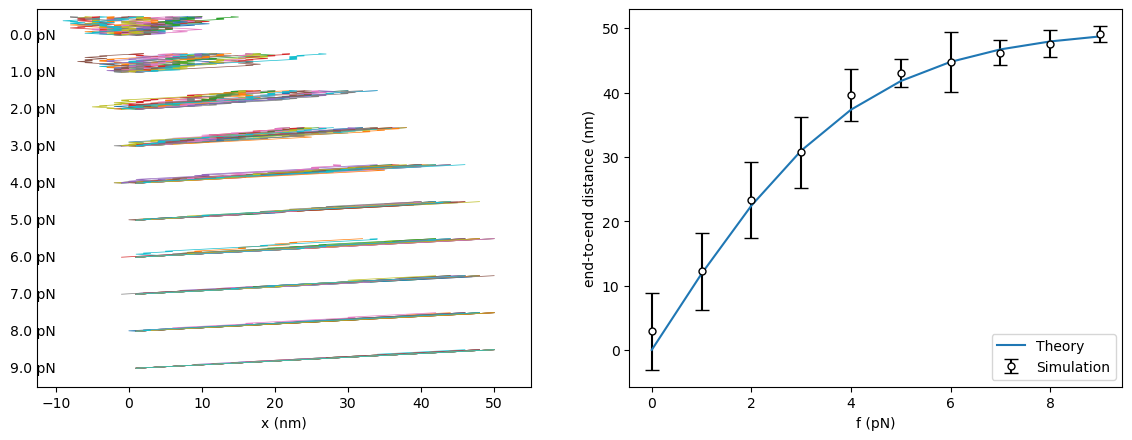

In [1]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ
    
kB = 1.381E-23 # ボルツマン定数
T = 300  # (J = kg m^2 / s^2)

# 長さ Nの高分子を作り，力 f がかかっている状態で，stepN回の遷移を行う．
def polymer(N, stepN, f):
    s = np.random.randint(0,2,N)*2-1  # 高分子を作る
    for i in range(stepN):
        k = np.random.randint(0, N) # 反転させるセグメントの候補
            
        p0 = 0.01 # 適当な数字． pが1を超えないように小さい値にする．
        p = p0*np.exp(-s[k]*f*d/kB/T)  # 反転（距離が 2d 変化） に伴う自由エネルギー変化は  ΔG = ±2fd．これを，前向き遷移と後ろ向き遷移で半分ずつ分けることにして，結局，expの中は ΔG/2 = ±fd の分だけ．

        if np.random.rand() < p:
            s[k] = -s[k]                
    return s


# 同じ計算を10回して重ねてプロット．まとめて，MSDを計算．
N = 50 # 高分子のセグメント数 （L = Nd）

stepN = 10000 # 計算ステップ数．この時間が経ったときの末端間距離を考える．
d = 1E-9 # 高分子の1セグメントの長さ (m)


M = 10 # 張力を何パターン変えるか
f = np.arange(M)*1E-12 # 張力 (N)

l_mean, l_std = [], [] # 末端間距離の平均値と標準偏差

fig, (ax1, ax2) = plt.subplots(ncols =2, figsize=(14, 5), dpi = 100)
for q in range(M):
    n = 20 # 1つの力に対して何本の高分子を考えるか．誤差を減らすにはこれを大きくする．
    l = [] # 末端間距離
    for m in range(n):
        s = polymer(N, stepN, f[q])
            
        x = np.cumsum(s)*d
        y = np.linspace(0, 0.5, N)    

        ax1.plot(x*1E9, y - q, lw = 0.5)  # lwは線の太さ．
        
        l.append(x[N-1])
    
    l_mean.append(np.mean(l))
    l_std.append(np.std(l))
    
    ax1.text(-10, -q, "{:.1f} pN".format(f[q]*1E12), horizontalalignment="right", verticalalignment="center")
    
ax1.set_xlabel('x (nm)')
ax1.set_xlim([-N*0.25, N*1.1])
ax1.set_ylim([-M+0.5, 0.7])
ax1.set_yticks([])

ax2.errorbar(f*1E12, np.array(l_mean)*1E9, yerr = np.array(l_std)*1E9, capsize=5, fmt='o', markersize=5, ecolor='black', markeredgecolor = "black", color='w', label = 'Simulation')
ax2.plot(f*1E12, N*d*np.tanh(f*d/kB/T)*1E9, label = 'Theory')
ax2.set_xlabel('f (pN)')
ax2.set_ylabel('end-to-end distance (nm)')
ax2.legend(loc = 'lower right')

plt.show()

# S2 枯渇力

- 2つの大きな粒子（半径 rL）と，N-2個の小さな粒子（半径 rS）がブラウン運動．
- 大きな粒子の厚み rDの領域には小さな粒子は接近できない．大きな粒子は接近できる．
- この排除体積のため，大きな粒子同士には引力が働く．すなわち，大きな粒子同士が近づいた方が，小さいな粒子にいは動けるスペースが増えるのでエントロピー的に得．
- 小さい粒子同士には相互作用はない．すれ違える．
- 周期境界で計算．セルの端っこにいると逆側にも粒子が表示される．

7.6節参照

平均距離 = 6.96 um


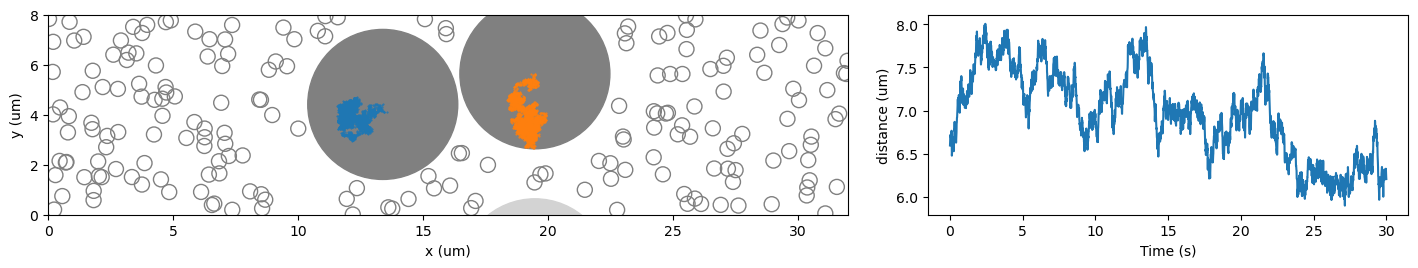

In [2]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

kBT = 4.14E-21  # (J = kg m^2 / s^2)

N = 200 # 粒子数（大きい粒子を含むので，最低 2）．多すぎると初期配置ができず無限ループに陥るので注意．
Lx, Ly = 32E-6, 8E-6 # 容器サイズ (um)
rL, rS = 3E-6, 0.3E-6 # 大きい粒子と小さい粒子の半径
a =1E-9
f0 = 1E-8
gamma0 = 1E-8 # 半径0.5umの時の摩擦係数 (kg/s) 
   
T = 30 # (s) 計算時間
dt = 1E-2 # (s) 計算の時間刻み


# メインの関数．ランジュバン方程式をオイラー法で数値積分．
def langevin(dt, T):  # 時間刻み dt で T だけ計算   
    
    r = np.full(N, rS) # 半径
    r[0], r[1] = rL, rL
    
    gamma= gamma0 *r/0.5E-6 # 摩擦係数        
    w = np.sqrt(2*kBT*dt/gamma)  # ルートの中にdtを入れる
            
    # 粒子を配置    
    x = np.zeros(N)
    y = np.zeros(N)    
    
    x[0], x[1] = Lx/2-rL*1.1, Lx/2+rL*1.1 # 大きな粒子の初期位置は固定する．微妙な距離でスタート
    y[0], y[1] = Ly/2, Ly/2
    
    for k in range(2, N): # 大きな粒子と被らないように小さな粒子を配置
        while True:
            x[k] = np.random.rand()*Lx
            y[k] = np.random.rand()*Ly
            
            d0 = np.sqrt((x[k]-x[0])*(x[k]-x[0]) + (y[k]-y[0])*(y[k]-y[0]))
            d1 = np.sqrt((x[k]-x[1])*(x[k]-x[1]) + (y[k]-y[1])*(y[k]-y[1]))          
            
            if (d0 > r[k] + r[0]  + 30E-9) and (d1 > r[k] + r[1]  + 30E-9):
                break
    
    stepN = int(T / dt)  # ステップ数
    sx = np.zeros((stepN, 2)) # 大きな粒子は時系列を記録しておく．
    sy = np.zeros((stepN, 2))
    
    for i in range(stepN):
        
        # 相互作用の計算
        fx = np.zeros(N)
        fy = np.zeros(N)
        for k in range(N):   
            if k<=1:
                xx, yy, rr = x, y, r
            else:
                xx, yy, rr = x[:2], y[:2], r[:2]
            
            dx = (xx - x[k] +Lx/2)%Lx - Lx/2
            dy = (yy - y[k] +Ly/2)%Ly - Ly/2
            
            d = np.sqrt(dx*dx + dy*dy) - (r[k] + rr)          
            d = np.clip(d, 20E-9,1)
            
            ff = -f0*12/a*np.power(d/a, -13)/d
            
            fx[k] = np.sum(ff*dx)  # U(r) = (r/ a)^(-12), dUdr = -12/a*(r/a)^(-13)
            fy[k] = np.sum(ff*dy)
                
        x = (x + dt * fx/gamma + w*np.random.standard_normal(N)) % Lx
        y = (y + dt * fy/gamma + w*np.random.standard_normal(N)) % Ly
                
        sx[i,:] = x[0:2]
        sy[i,:] = y[0:2]
        
    return x, y, r, sx, sy

x, y, r, sx, sy = langevin(dt, T) # 計算

# 左の図
fig = plt.figure(figsize=(16,2), dpi=100.0)

ax1 = fig.add_axes([0, 0,0.5 , 1], xlabel = 'x (um)', ylabel = 'y (um)')

ax1.set_xlim(0, Lx*1E6)
ax1.set_ylim(0, Ly*1E6)

# 円のプロット．軸と大きさを合わせるため，Circleを用いている．また，はみだした分も表示するため，大きな粒子については ずらした場所にもプロットする．
lx = [Lx, -Lx, 0, 0, Lx, Lx, -Lx, -Lx]
ly = [0, 0, Ly, -Ly, Ly, -Ly, -Ly, Ly]

for i in range(N):
    ax1.add_artist(plt.Circle((x[i]*1E6, y[i]*1E6), r[i]*1E6, color = 'gray', fill = (i < 2)))
    if i<2:
        for llx, lly in zip(lx, ly):
            ax1.add_artist(plt.Circle(((x[i]+llx)*1E6, (y[i]+lly)*1E6), r[i]*1E6, color = 'lightgray', fill = (i < 2)))
        ax1.plot(sx[:, i]*1E6, sy[:, i]*1E6, '.', markersize = 1)
    
# 大きい粒子間の距離の時系列
ax2 = fig.add_axes([0.55, 0, 0.3, 1], xlabel = 'Time (s)', ylabel = 'distance (um)')

dx = (sx[:,0]-sx[:,1]+Lx/2)%Lx-Lx/2
dy = (sy[:,0]-sy[:,1]+Ly/2)%Ly-Ly/2
d = np.sqrt(dx*dx+dy*dy)
t = np.linspace(0, T, len(d))   

print("平均距離 = {:.2f} um".format(np.mean(d*1E6)))

ax2.plot(t, d*1E6)
plt.show()